# Feature Visualization of Human Activity Recognition Systems

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import math
import numpy as np
import scipy.io as sio
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# mHealth Dataset
1) Experimental Setup

The collected dataset comprises body motion and vital signs recordings for ten volunteers of diverse profile while performing 12 physical activities (Table 1). 
Shimmer2 [BUR10] wearable sensors were used for the recordings. The sensors were respectively placed on the subject's chest, right wrist and left ankle and 
attached by using elastic straps (as shown in the figure in attachment). The use of multiple sensors permits us to measure the motion experienced by diverse body parts, 
namely, the acceleration, the rate of turn and the magnetic field orientation, thus better capturing the body dynamics. The sensor positioned
on the chest also provides 2-lead ECG measurements which are not used for the development of the recognition model but rather collected for future work purposes.
This information can be used, for example, for basic heart monitoring, checking for various arrhythmias or looking at the effects of exercise on the ECG. 
All sensing modalities are recorded at a sampling rate of 50 Hz, which is considered sufficient for capturing human activity. Each session was recorded using a video camera.
This dataset is found to generalize to common activities of the daily living, given the diversity of body parts involved in each one (e.g., frontal elevation of arms vs.
knees bending), the intensity of the actions (e.g., cycling vs. sitting and relaxing) and their execution speed or dynamicity (e.g., running vs. standing still). The activities
were collected in an out-of-lab environment with no constraints on the way these must be executed, with the exception that the subject should try their best when executing them.

2) Activity set

The activity set is listed in the following:

- L1: Standing still (1 min) 
- L2: Sitting and relaxing (1 min) 
- L3: Lying down (1 min) 
- L4: Walking (1 min) 
- L5: Climbing stairs (1 min) 
- L6: Waist bends forward (20x) 
- L7: Frontal elevation of arms (20x)
- L8: Knees bending (crouching) (20x)
- L9: Cycling (1 min)
- L10: Jogging (1 min)
- L11: Running (1 min)
- L12: Jump front & back (20x)

NOTE: In brackets are the number of repetitions (Nx) or the duration of the exercises (min).

3) Dataset files
The data collected for each subject is stored in a different log file: 'mHealth_subject<SUBJECT_ID>.log'.
Each file contains the samples (by rows) recorded for all sensors (by columns).
The labels used to identify the activities are similar to the ones presented in Section 2 (e.g., the label for walking is '4').
The meaning of each column is detailed next:

- Column 1: acceleration from the chest sensor (X axis)
- Column 2: acceleration from the chest sensor (Y axis)
- Column 3: acceleration from the chest sensor (Z axis)
- Column 4: electrocardiogram signal (lead 1) 
- Column 5: electrocardiogram signal (lead 2)
- Column 6: acceleration from the left-ankle sensor (X axis)
- Column 7: acceleration from the left-ankle sensor (Y axis)
- Column 8: acceleration from the left-ankle sensor (Z axis)
- Column 9: gyro from the left-ankle sensor (X axis)
- Column 10: gyro from the left-ankle sensor (Y axis)
- Column 11: gyro from the left-ankle sensor (Z axis)
- Column 13: magnetometer from the left-ankle sensor (X axis)
- Column 13: magnetometer from the left-ankle sensor (Y axis)
- Column 14: magnetometer from the left-ankle sensor (Z axis)
- Column 15: acceleration from the right-lower-arm sensor (X axis)
- Column 16: acceleration from the right-lower-arm sensor (Y axis)
- Column 17: acceleration from the right-lower-arm sensor (Z axis)
- Column 18: gyro from the right-lower-arm sensor (X axis)
- Column 19: gyro from the right-lower-arm sensor (Y axis)
- Column 20: gyro from the right-lower-arm sensor (Z axis)
- Column 21: magnetometer from the right-lower-arm sensor (X axis)
- Column 22: magnetometer from the right-lower-arm sensor (Y axis)
- Column 23: magnetometer from the right-lower-arm sensor (Z axis)
- Column 24: Label (0 for the null class)

*Units: Acceleration (m/s^2), gyroscope (deg/s), magnetic field (local), ecg (mV)c



In [3]:
# We have sensor reading along the 23 columns but we just want the sensor reading of acceleration from the right-lower-arm
# Those are in the columns 14 (x), 15(y), and 16 (z). we also hava acceleration from chest sensor in columns 0, 1, and 2, 
# and acceleration from left-ankle sensor in columns 5, 6, and 7. Also, the label is in column 23
mhealth_chest_location = [0, 1, 2, 23]
mhealth_left_ankle_location = [5, 6, 7, 23]
mhealth_right_wrist_location = [14, 15, 16, 23]

In [4]:
mhealth_folder = "data/MHEALTHDATASET/"

In [5]:
# Now the name of the activities
mhealth_activities = ['Standing',
                     'Sitting',
                     'Lying',
                     'Walking',
                     'Climbing Stairs',
                     'Waist Bend Forward',
                     'Frontal Elevation Arms',
                     'Knees Bending',
                     'Cycling',
                     'Jogging',
                     'Running',
                     'Jump Front & Back']

In [6]:
# read one subject data given subject id and sensor body position
def mhealth_read_one_subject(subject_id, body_position):
    filename = mhealth_folder + "mHealth_subject" + str(subject_id) + ".log"
    
    # Read the file
    df = pd.read_csv(filename, delim_whitespace = True, header = None)
    
    # Only keep the rows with defined class value
    df = df[df[23] != 0]
    
    df = df[body_position] #cannot leave the label out
    return df

In [7]:
# Windowing function 
def mhealth_windowing(data, window_length = 151, overlap_percent = 0.25):
    n_channels = data.shape[1]
    n_channels =  n_channels - 1    # since we also have the class labels
    
    # group the samples based on the class labels in column 23
    groups = data.groupby(23)
    
    # placeholders to save the data
    X_ = []
    Y_ = []
    
    # now loop over the groups and extract the windows with 50% overlap
    for gr in range(1, len(groups) + 1, 1):
        # get the data for that group 
        df_ = groups.get_group(gr)
        
        # Data and labels
        y = pd.unique(df_[23].values)
        x = df_.drop(23, axis=1).values
        
        # now windowing
        n_samples = len(x)
        
        # the number of window segments we will have without overlap
        n_blocks = n_samples // window_length
        n_upto = n_blocks * window_length
        
        # windowing with overlap_percent % overlap
        tp = []
        n_start = 0
        n_end = n_start + window_length
        overlap_length = int(overlap_percent * window_length)
        
        while n_end < n_samples:
            tp.append(x[n_start:n_end])
            n_start = n_end - overlap_length
            n_end = n_start + window_length
        
        # save the data
        X_.append(tp)
        Y_.append(np.array([y] * len(tp), dtype=int).squeeze())
        
    
    # Concatenate and return the data
    X = np.concatenate(X_, axis=0)
    Y = np.concatenate(Y_, axis=0)
    
    return X, Y

In [8]:
# extract and merge all the subjects data into one file
def mhealth_merge_all(window_length, overlap_percent):
    body_position = mhealth_chest_location
    X_ = []
    Y_ = []
    
    total_subject = 10 + 1
        
    for s in range(1, total_subject, 1):
        # read the current subject data
        df = mhealth_read_one_subject(s, body_position)

        # Apply the windowing to the data
        s_x, s_y = mhealth_windowing(df, window_length, overlap_percent)

        # add to the list
        X_.append(s_x)
        Y_.append(s_y)
        
    # concatenate and save all
    X = np.concatenate(X_, axis=0)
    Y = np.concatenate(Y_, axis=0)
    
    return X, Y

In [9]:
def combine_components(df, window_length):
    
    n_samples = df.shape[0]
    X = np.zeros((n_samples, window_length * 3))

    for i in range(n_samples):
        # get the window data at position i
        dp = df[i]

        # placeholders to store the x, y, and z component of the window data
        x = []
        y = []
        z = []
        for q in dp:
            x.append(q[0])
            y.append(q[1])
            z.append(q[2])

        # save the x, y, and z as a single array
        X[i] = np.concatenate((x, y, z))
        
    return X

In [10]:
n_window_length = 128
overlap = 0.5

m_X, m_Y = mhealth_merge_all(n_window_length, overlap)
m_health_data = combine_components(m_X, n_window_length)
m_Y = np.array(m_Y) - 1

df_colnames = []
for i in range(n_window_length):
    df_colnames.append('ACC-X-'+str(i))

for i in range(n_window_length):
    df_colnames.append('ACC-Y-'+str(i))

for i in range(n_window_length):
    df_colnames.append('ACC-Z-'+str(i))

mhealth_df = pd.DataFrame(m_health_data, columns=df_colnames)
mhealth_df['Class'] = m_Y
file = open('results/mhealth_window_size_' + str(n_window_length) + '.pickle', 'wb')
pickle.dump([mhealth_df, mhealth_activities], file)
file.close()

In [11]:
file = open('results/mhealth_window_size_' + str(n_window_length) + '.pickle', 'rb')
mhealth_df, _ = pickle.load(file)
file.close()

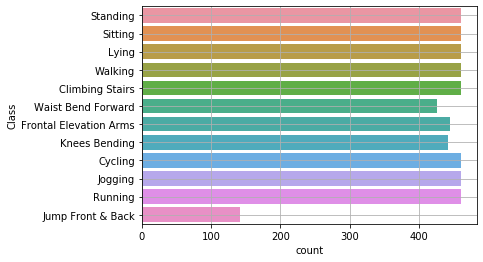

In [12]:
ax = sns.countplot(data = mhealth_df, y = 'Class')
ax.set_yticklabels(mhealth_activities)
ax.grid()